## import libraries and run consumer

In [1]:
from kafka import KafkaConsumer
import pandas as pd

In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

## load the pipeline_dynamic

In [3]:
# load the pipeline_dynamic
import pickle
with open('pipe.pkl', 'rb') as f:
    pipeline_dynamic = pickle.load(f)
with open('pipe.pkl', 'rb') as f:
    pipeline_static = pickle.load(f)    


## static data

In [4]:

static_data =pd.read_csv('C:/Users/Welcome/OneDrive/Desktop/uottawa/Second Term/AI foe CS/Assignments/A3/Env/data/Static_dataset.csv')
new_features =['FQDN_count', 'subdomain_length', 'lower', 'numeric', 'special',
       'labels', 'longest_word', 'len', 'subdomain']
static_data.dropna(inplace=True)
static_data.drop_duplicates(inplace=True)
static_data.drop(['timestamp'], axis=1, inplace=True)
static_data['longest_word'] = static_data['longest_word'].apply(lambda x: hash(x))
X_static = static_data[new_features]
y_static = static_data['Target Attack']
y_pred = pipeline_dynamic.predict(X_static)
y_pred
# print the f1 score
from sklearn.metrics import f1_score
print(f"{f1_score(y_static, y_pred, average='macro')*100} %")

77.8434624223865 %


## dynamic data

In [5]:
def get_dns():
    c =[]
    for i in range(1000):
        for m in consumer:
            c.append(m.value)
            break
    return c

def batch_df(messages):
    X=[]
    y=[]
    for message in messages:
        message_str = message.decode('utf-8')
        message_str = message_str.strip('"')
        features = message_str.split(',')
        features = features[:-1]
        X.append(features)
        y.append(features[-1])
    dynamic_data = pd.DataFrame(X, columns=['timestamp', 'FQDN_count', 'subdomain_length', 'upper', 'lower','numeric', 'entropy', 'special', 'labels', 'labels_max','labels_average', 'longest_word', 'sld', 'len', 'subdomain'])
    dynamic_data['Target Attack'] = y
    return dynamic_data

# messages = batch_df(get_dns())
# messages
f1_results_dynamic = []
f1_results_stataic = []
messages = get_dns()
dynamic_data = batch_df(messages)
dynamic_data['longest_word'] = dynamic_data['longest_word'].apply(lambda x: hash(x))
dynamic_data = dynamic_data.drop([0]).reset_index(drop=True)
X_dynamic = dynamic_data[new_features].astype(float)
y_dynamic = dynamic_data['Target Attack'].astype(int)
y_pred    = pipeline_dynamic.predict(X_dynamic)
f1_dynamic = f1_score(y_dynamic, y_pred, average='macro')
f1_results_dynamic.append(f1_dynamic)
f1_results_stataic.append(f1_dynamic)
print(f1_results_dynamic)
print(f1_results_stataic)

[0.8786888252262612]
[0.8786888252262612]


In [6]:
j = 1
threshold = 0.87
for i in range(200):
    print(f'batch{i}')
    messages = get_dns()
    dynamic_data = batch_df(messages)
    dynamic_data['longest_word'] = dynamic_data['longest_word'].apply(lambda x: hash(x))
    dynamic_data = dynamic_data.dropna().reset_index(drop=True)
    dynamic_data = dynamic_data.drop('timestamp', axis=1)
    X_dynamic = dynamic_data[new_features]
    y_dynamic = dynamic_data['Target Attack'].astype(int)
    y_pred_dynamic = pipeline_dynamic.predict(X_dynamic)
    y_pred_static = pipeline_static.predict(X_dynamic)
    f1_dynamic = f1_score(y_dynamic, y_pred_dynamic, average='macro')
    f1_results_dynamic.append(f1_dynamic)
    print(f'f1 dynamic{f1_dynamic}')


    f1_static = f1_score(y_dynamic, y_pred_static, average='macro')
    f1_results_stataic.append(f1_static)
    # print(f1_results_dynamic)
    if f1_dynamic < threshold:
        print(f'retrain {j}')
        j+=1
        #concatenate the static and dynamic data
        new_df = pd.concat([static_data, dynamic_data], ignore_index=True)
        static_data = new_df
        X = new_df[new_features].astype(float)
        y = new_df['Target Attack'].astype(int)
        #retrain the model
        pipeline_dynamic.fit(X, y)
        y_pred = pipeline_dynamic.predict(X)
        f1_dynamic = f1_score(y, y_pred, average='macro')
        print(f'f1 dynamic after retrain{f1_dynamic}')


batch0
f1 dynamic0.8669895076674738
retrain 1
f1 dynamic after retrain0.7872117533359175
batch1
f1 dynamic0.8632922215759673
retrain 2
f1 dynamic after retrain0.7877115536551366
batch2
f1 dynamic0.8528948197961543
retrain 3
f1 dynamic after retrain0.7882123034673393
batch3
f1 dynamic0.8818644306368261
batch4
f1 dynamic0.8571701230232914
retrain 4
f1 dynamic after retrain0.7886788140124719
batch5
f1 dynamic0.8894149269032667
batch6
f1 dynamic0.8827201361959709
batch7
f1 dynamic0.8540758676351896
retrain 5
f1 dynamic after retrain0.7891336182131017
batch8
f1 dynamic0.8630513974626686
retrain 6
f1 dynamic after retrain0.7896252849425784
batch9
f1 dynamic0.8786177197019274
batch10
f1 dynamic0.8656798245614036
retrain 7
f1 dynamic after retrain0.7901355512652948
batch11
f1 dynamic0.8491991682143595
retrain 8
f1 dynamic after retrain0.790565425593498
batch12
f1 dynamic0.8597968979376398
retrain 9
f1 dynamic after retrain0.7910394359087343
batch13
f1 dynamic0.8730832689134773
batch14
f1 dynam

In [7]:
print(len(f1_results_dynamic))
print(len(f1_results_stataic))

201
201


## results

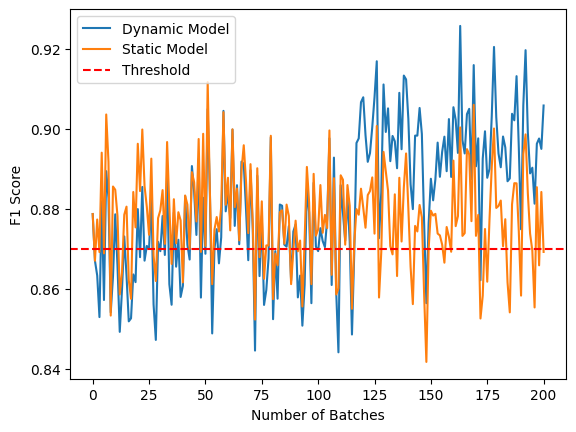

In [8]:
#plot the f1 score
import matplotlib.pyplot as plt
plt.plot(f1_results_dynamic)
plt.plot(f1_results_stataic)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Number of Batches')
plt.ylabel('F1 Score')
plt.legend( ['Dynamic Model', 'Static Model', 'Threshold'])
plt.show()



In [9]:
# print the avg f1 score for dynamic model and static model
print(f"Average F1 score for dynamic model: {sum(f1_results_dynamic)/len(f1_results_dynamic)}")
print(f"Average F1 score for static model:  {sum(f1_results_stataic)/len(f1_results_stataic)}")


Average F1 score for dynamic model: 0.8820091916733049
Average F1 score for static model:  0.8775597697259105
